In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
# Set random seeds for reproducing results
torch.manual_seed(42)

In [3]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [9]:
df = pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df.shape

(60000, 785)

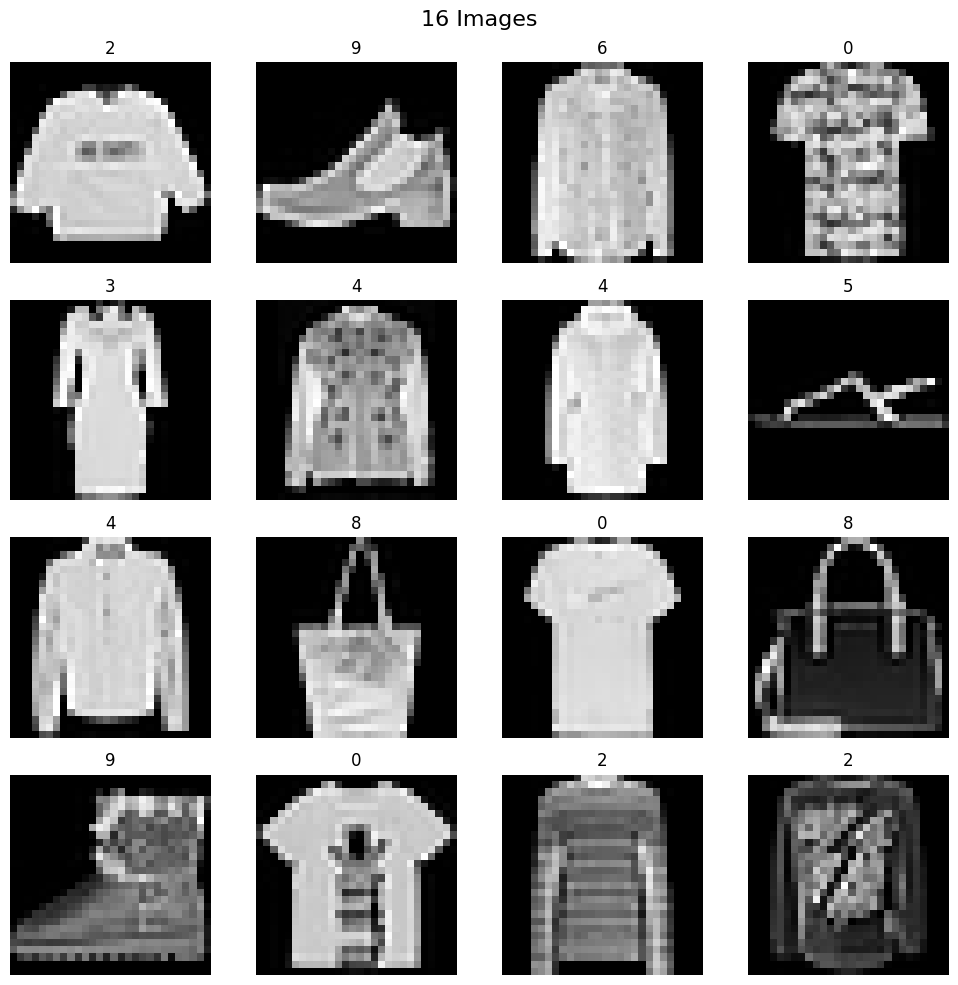

In [11]:
# creating a grid of 4x4
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("16 Images", fontsize=16)

# Plot 16 images from dataset
for i, ax in enumerate(axes.flatten()):
  img = df.iloc[i, 1:].values.reshape(28, 28)
  ax.imshow(img, cmap='gray')
  ax.axis('off')
  ax.set_title(df.iloc[i, 0])

plt.tight_layout()
plt.show()

In [13]:
# train test split
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Scaling
X_train = X_train / 255.0
X_test = X_test / 255.0

In [15]:
class MyDataset(Dataset):

  def __init__(self, features, labels):

    # Convert to tensors
    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [16]:
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

In [18]:
class NeuralNet(nn.Module):

  def __init__(self, input_dim, output_dim, n_hidden, n_neurons, dropout_rate):

    super().__init__()

    layers = []

    for i in range(n_hidden):
      layers.append(nn.Linear(input_dim, n_neurons))
      layers.append(nn.BatchNorm1d(n_neurons))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))

      input_dim = n_neurons

    layers.append(nn.Linear(n_neurons, output_dim))

    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

In [29]:
# Objective function for Bayesian Optim via Optuna
def objective(trial):

  # next hyperparameter values from the search space
  n_hidden = trial.suggest_int("n_hidden", 1,6)
  n_neurons = trial.suggest_int("n_neurons", 8, 256, step=8)
  epochs = trial.suggest_int("epochs", 10, 50, step = 10)
  batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
  dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=0.1)
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

  train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, pin_memory=True)

  # initialize model
  input_dim = X_train.shape[1]
  output_dim = 10
  model = NeuralNet(input_dim, output_dim, n_hidden, n_neurons, dropout_rate).to(device)

  # optimizer selection
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  if optimizer_name == "Adam":
    optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == "RMSprop":
    optim.RMSprop
  else:
    optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # training loop

  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      output = model(batch_features)

      # calculate loss
      loss = criterion(output, batch_labels)

      # backward pass
      optimizer.zero_grad()
      loss.backward()

      # update gradients
      optimizer.step()

  # evaluation time
  model.eval()
  total_loss = 0
  total_correct = 0

  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
      output = model(batch_features)
      _, predicted = torch.max(output, 1)
      total_loss += batch_labels.shape[0]
      total_correct += (predicted == batch_labels).sum().item()

    accuracy = total_correct / total_loss
    return accuracy

In [23]:
!pip install optuna

In [30]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2025-02-26 08:46:33,608] A new study created in memory with name: no-name-09632874-7a8e-492e-afe0-e9cd355851d9
[I 2025-02-26 08:48:29,325] Trial 0 finished with value: 0.7315833333333334 and parameters: {'n_hidden': 6, 'n_neurons': 200, 'epochs': 40, 'batch_size': 64, 'dropout_rate': 0.1, 'optimizer': 'SGD', 'learning_rate': 1.908399829749014e-05, 'weight_decay': 4.440434447186325e-06}. Best is trial 0 with value: 0.7315833333333334.
[I 2025-02-26 08:48:58,154] Trial 1 finished with value: 0.8700833333333333 and parameters: {'n_hidden': 5, 'n_neurons': 216, 'epochs': 20, 'batch_size': 128, 'dropout_rate': 0.4, 'optimizer': 'Adam', 'learning_rate': 0.011949877747710523, 'weight_decay': 0.00020234761934658104}. Best is trial 1 with value: 0.8700833333333333.
[I 2025-02-26 08:49:26,456] Trial 2 finished with value: 0.878 and parameters: {'n_hidden': 1, 'n_neurons': 152, 'epochs': 20, 'batch_size': 64, 'dropout_rate': 0.4, 'optimizer': 'Adam', 'learning_rate': 0.024279402899701315, 'wei

In [33]:
study.best_value

0.8946666666666667

In [34]:
study.best_params

{'n_hidden': 5,
 'n_neurons': 240,
 'epochs': 30,
 'batch_size': 64,
 'dropout_rate': 0.4,
 'optimizer': 'RMSprop',
 'learning_rate': 0.0695612819239576,
 'weight_decay': 2.8331337574563826e-05}

In [31]:
# Uploading multiple notebooks to GitHub via single commit
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
# Navigate to repo directory
!ls "/content/drive/MyDrive/Colab Notebooks"

[Errno 2] No such file or directory: 'pytorch-tutorials'
/content
 01-getting_started.ipynb		      dl-ylc
 01_tensor-basics.ipynb			      GD_1.ipynb
 02-deployment.ipynb			      houseprices-regression.ipynb
 02pytorch-tensors.ipynb		      learn-NetworkX.ipynb
 03_autograd-engine.ipynb		      ml.ipynb
 03autograd.ipynb			      ml.ipynb.ipynb
 04_backprop.ipynb			      MNIST_Image_Classification.ipynb
 04training-pipeline.ipynb		      mnist-using-numpy.ipynb
 06-convnet.ipynb			      PDL01.ipynb
 06-dataset_dataloader.ipynb		      RollNumber_PA2_1.ipynb
 07-ann_fashionmnist.ipynb		      RollNumber_PA2_2.ipynb
 08-ann_optimized.ipynb			      titanic-classification.ipynb
 10-hyperparameter_tuning.ipynb		      Untitled
 cnn_dogs-vs-cats.ipynb			      Untitled0.ipynb
 cnn_mnist.ipynb			      Untitled1.ipynb
'Copy of 00-logic_neuron_programming.ipynb'   Untitled2.ipynb
'Copy of ml.ipynb'			      Untitled3.ipynb
'Copy of nn_tutorial.ipynb'		      Untitled4.ipynb
'Copy of RollNumber_PA2_1.ipynb

In [39]:
%cd /content
!git clone https://github.com/hasanfaesal/pytorch-tutorials.git
%cd pytorch-tutorials

/content
Cloning into 'pytorch-tutorials'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 16 (delta 5), reused 7 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 27.07 KiB | 13.54 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/pytorch-tutorials


In [42]:
!ls
!cp "/content/drive/MyDrive/Colab Notebooks/06-dataset_dataloader.ipynb" .
!cp "/content/drive/MyDrive/Colab Notebooks/07-ann_fashionmnist.ipynb" .
!cp "/content/drive/MyDrive/Colab Notebooks/08-ann_optimized.ipynb" .
!cp "/content/drive/MyDrive/Colab Notebooks/10-hyperparameter_tuning.ipynb" .

 02pytorch_tensors.ipynb   04training_pipeline.ipynb
 02tensors.ipynb	  '05(1)nn_module.ipynb'
 03autograd.ipynb	  '05(2)training_pipeline_using_nn_module.ipynb'


In [40]:
!git config --global user.email "hasanfaesal@outlook.com"
!git config --global user.name "hasanfaesal"

In [41]:
!git add

fatal: pathspec '06-dataset_dataloader.ipynb' did not match any files
